In [1]:
library(ggvenn)
library(tidyverse)
library(RColorBrewer)
library(eulerr)
library(ggplotify)

# Custom package
library(rutils)

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: grid

Loading required package: ggplot2

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.6     v purrr   0.3.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("CESC", "UCS", "UCEC")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [3]:
text_size <- 8
guide_size <- 1
family <- "ArialMT"
dpi <- 320
vd_ht <- 3
vd_wd <- vd_ht
label_size <- 10

In [4]:
demg_files <- paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets, "_demg_list.txt")
figo_umsmg_files <- paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets, "_figo_umsmg_list.txt")
figo_nsmg_files <- paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets, "_figo_nsmg_list.txt")
survival_files <- paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets, "_survival_umsmg_list.txt")

In [5]:
demg_lists <- list()
figo_lists <- list()
survival_lists <- list()

for (i in 1:3) {
    demg_lists[[unified_dsets[i]]] <- read_lines(demg_files[i])
    figo_umsmg_list <- read_lines(figo_umsmg_files[i])
    figo_nsmg_list <- read_lines(figo_nsmg_files[i])
    figo_lists[[unified_dsets[i]]] <- figo_umsmg_list %>%
        union(figo_nsmg_list) %>%
        intersect(demg_lists[[unified_dsets[[i]]]])
    survival_lists[[unified_dsets[i]]] <- read_lines(survival_files[i]) %>%
        intersect(demg_lists[[unified_dsets[[i]]]])
}
matrisome_df <- load_matrisome_df(matrisome_path)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)




In [6]:
venn_df <- tibble(geneID = matrisome_df$gene_symbol) %>%
    # DEMGs
    dplyr::mutate(cesc_demg = geneID %in% demg_lists$unified_cervical_data) %>%
    dplyr::mutate(ucs_demg = geneID %in% demg_lists$unified_uterine_data) %>%
    dplyr::mutate(ucec_demg = geneID %in% demg_lists$unified_uterine_endometrial_data) %>%
    # Univar
    dplyr::mutate(cesc_figo = geneID %in% figo_lists$unified_cervical_data) %>%
    dplyr::mutate(ucs_figo = geneID %in% figo_lists$unified_uterine_data) %>%
    dplyr::mutate(ucec_figo = geneID %in% figo_lists$unified_uterine_endometrial_data) %>%
    # Network
    dplyr::mutate(cesc_survival = geneID %in% survival_lists$unified_cervical_data) %>%
    dplyr::mutate(ucs_survival = geneID %in% survival_lists$unified_uterine_data) %>%
    dplyr::mutate(ucec_survival = geneID %in% survival_lists$unified_uterine_endometrial_data)

In [7]:
venn_pal <- brewer.pal(n = 3, name = "Set2")
# venn_pal <- c("#F8766D", "#00BA38", "#619CFF")

In [8]:
make_inter_venn <- function (df, map, title = "") {
    ggplot(data = df) +
        geom_venn(
            map,
            fill_color = venn_pal,
            fill_alpha = 0.7,
            set_names = c("CESC", "UCS", "UCEC"),
            show_percentage = FALSE
        ) +
        theme_void() +
        theme(
            text = element_text(size = text_size, family = family)
#             plot.title = element_text(face = "bold", size = label_size)
        )
}

In [9]:
# make_inter_venn(venn_df, aes_string(A = "cesc_demg", B = "ucs_demg", C = "ucec_demg"), title = "DEMG Overlaps")
# # ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/demg_inter_overlap_venn.png"), last_plot(), height = vd_ht, width = vd_wd)
# make_inter_venn(venn_df, aes_string(A = "cesc_figo", B = "ucs_figo", C = "ucec_figo"), title = "FIGO Overlaps")
# # ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/umsmg_inter_overlap_venn.png"), last_plot(), height = vd_ht, width = vd_wd)
# make_inter_venn(venn_df, aes_string(A = "cesc_survival", B = "ucs_survival", C = "ucec_survival"), title = "survival Overlaps")
# # ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/nsmg_inter_overlap_venn.png"), last_plot(), height = vd_ht, width = vd_wd)

In [10]:
# quantites_list <- list(fontsize = text_size - 2, col = "gray10")
quantites_list <- list(fontsize = label_size, col = "gray10")
# quantites_list <- list(fontsize = label_size, col = "gray10")
edges_list <- list(lwd = 1, alpha = .5, col = "gray80")
# labels_list <- list(fontsize = (text_size - 2))
labels_list <- list(fontsize = (label_size))
# labels_list <- list(fontsize = (label_size))
# Must be in same order as DF columns (CESC, UCS, UCEC)
fills_list <- list(fill = c(CESC = "#ffd8c7", UCS = "#5cd2d9", UCEC = "#ff6927"))


make_inter_euler <- function(venn_df, suffix) {
    demg_euler_df <- venn_df %>%
    column_to_rownames("geneID") %>%
    dplyr::select(ends_with(suffix)) %>%
    dplyr::rename_with(~ gsub(paste0("_", suffix), "", .)) %>%
    dplyr::rename_with(~ toupper(.))
    set.seed(123)
    
    euler(demg_euler_df, shape = "circle")
}

plot_euler <- function(fit) {
    plot(
        fit,
        quantities = quantites_list,
        edges = edges_list,
        alpha = 0.7,
        labels = labels_list,
        fills = venn_pal
    ) %>% as.ggplot()
}

In [11]:
venn_counts_df <- venn_df %>%
    mutate(
        demg_any = cesc_demg + ucs_demg + ucec_demg > 0,
        figo_any = cesc_figo + ucs_figo + ucec_figo > 0,
        surv_any = cesc_survival + ucs_survival + ucec_survival > 0
    ) %>%
    select(geneID, demg_any, figo_any, surv_any)
venn_counts_df$demg_any %>% sum()
venn_counts_df$figo_any %>% sum()
venn_counts_df$surv_any %>% sum()

[1] 839

[1] 476

[1] 76

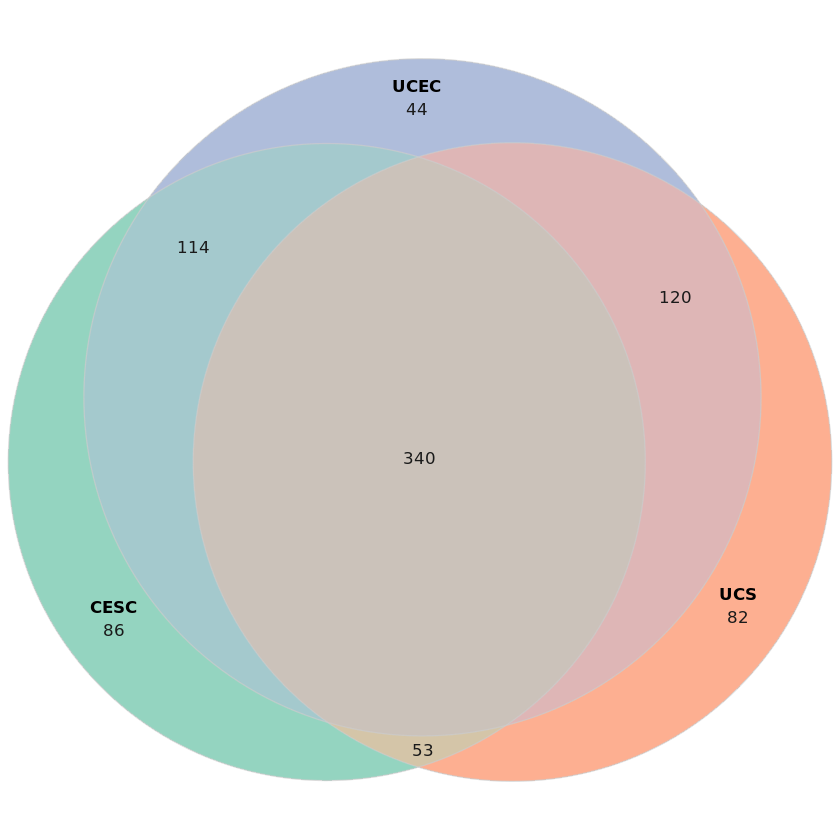

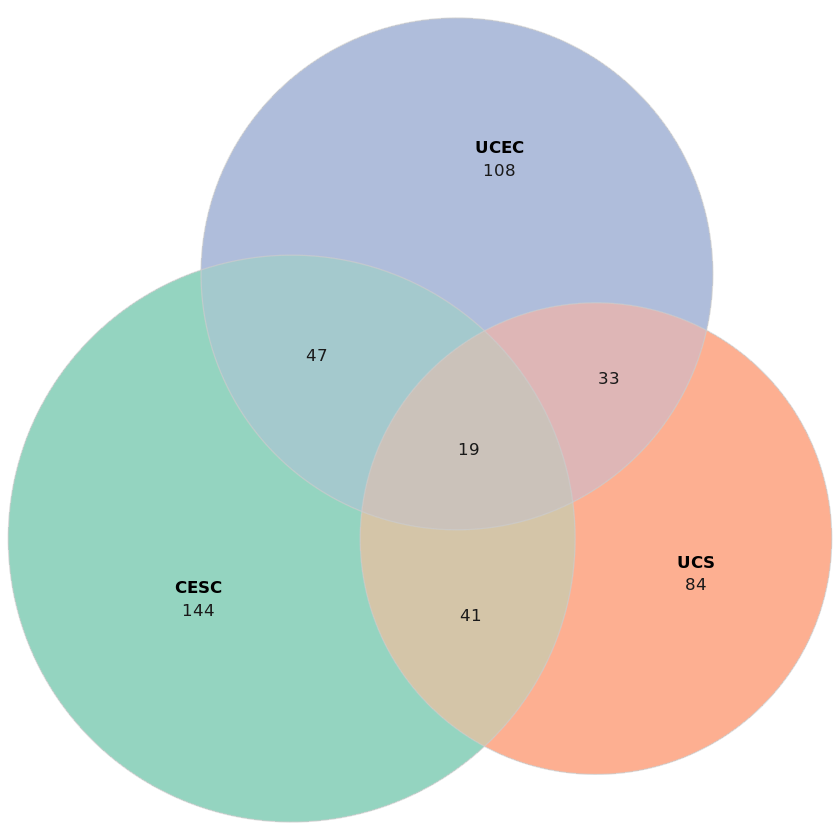

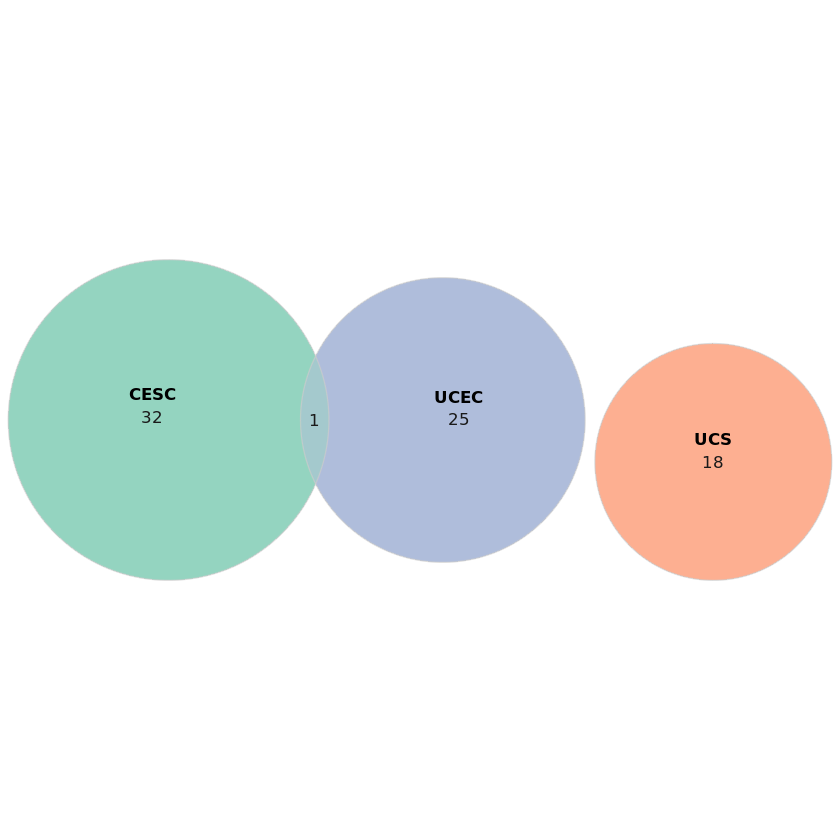

In [12]:
demg_euler_fit <- make_inter_euler(venn_df, "demg")
plot_euler(demg_euler_fit)
demg_inter <- last_plot()
ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/demg_inter_overlap_euler.png"), demg_inter, height = vd_ht, width = vd_wd)

figo_euler_fit <- make_inter_euler(venn_df, "figo")
plot_euler(figo_euler_fit)
figo_inter <- last_plot()
ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/figo_inter_overlap_euler.png"), figo_inter, height = vd_ht, width = vd_wd)

survival_euler_fit <- make_inter_euler(venn_df, "survival")
plot_euler(survival_euler_fit)
survival_inter <- last_plot()
ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/survival_inter_overlap_euler.png"), survival_inter, height = vd_ht, width = vd_wd)

In [13]:
save(
    list = c("demg_inter", "figo_inter", "survival_inter"),
    file = paste0(dirs$figures_dir, "/saved_obj/gene_interplots.RData")
)